## Mise en place

In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold, train_test_split
import spacy
from io import StringIO
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, classification_report
from fastapi import FastAPI, Request
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import mlflow
import mlflow.pytorch
from sklearn.naive_bayes import MultinomialNB
import mlflow.sklearn
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
import mlflow.keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import kagglehub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Préparation des données

In [3]:
# Charger le modèle anglais de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour nettoyer le texte
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s#]', '', text).lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Fonction pour lemmatiser le texte
def lemmatize_text(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Paramètres du modèle
max_words = 15000
max_len = 60

# Chemin vers le fichier CSV contenant les données de catégories
fichier = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_007/Rendu/training_1600000_processed_noemoticon.csv'

with open(fichier, 'rb') as file:
    bytes_data = file.read()
    decoded_data = bytes_data.decode('latin-1')

data = pd.read_csv(StringIO(decoded_data))

# Liste des noms de colonnes
noms_colonnes = ['Groupe', 'id_uti', 'date_voyage', 'requete', 'pseudo_uti', 'tweet']
data = pd.read_csv(StringIO(decoded_data), names=noms_colonnes, header=None)

# Utiliser seulement x% des données pour le développement initial
data = data.sample(frac=0.02, random_state=42)

# Application des fonctions de nettoyage sur la colonne 'tweet'
data['tweet'] = data['tweet'].fillna('')
data['cleaned_tokens'] = data['tweet'].apply(clean_text)
data['cleaned_text'] = data['cleaned_tokens'].apply(lambda x: ' '.join(x))

# Tokenizer pour convertir les tweets en séquences de tokens
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# Padding des séquences pour les rendre de longueur égale
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(data['Groupe'].map({0: 0, 4: 1}))

# Lemmatisation
data['lemmatized_tokens'] = data['cleaned_tokens'].apply(lemmatize_text)

# Entrainement du modèle Word2Vec
word2vec_model = Word2Vec(sentences=data['lemmatized_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Transformation des textes en vecteurs Word2Vec
data['word2vec_vectors'] = data['lemmatized_tokens'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x if word in word2vec_model.wv], axis=0))

# Charger le modèle USE depuis Kaggle
use_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

# Fonction pour obtenir l'embedding USE
def embed_use(text):
    return use_model([text]).numpy().flatten()

# Embedding des textes avec USE
data['use_embeddings'] = data['lemmatized_tokens'].apply(lambda x: embed_use(" ".join(x)))

# Préparation des données pour l'entraînement
data['labels'] = data['Groupe'].apply(lambda x: 1 if x == 4 else 0)
data = data[['tweet', 'labels', 'word2vec_vectors', 'use_embeddings']]

# Séparer les données en jeu d’entraînement (70%), jeu de validation (15%) et jeu de test (15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(data['tweet'], data['labels'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Convertir les données textuelles en numpy arrays
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Padding des séquences pour les rendre de longueur égale
train_texts = pad_sequences(train_sequences, maxlen=max_len)
val_texts = pad_sequences(val_sequences, maxlen=max_len)

# Convertir les labels en numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## LSTM

In [4]:
# Construction du modèle LSTM
def build_model(max_words, max_len, embedding_dim=100, lstm_units=128, dropout_rate=0.5, learning_rate=0.001, l2_reg=0.01):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        LSTM(int(lstm_units / 2), kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configurer MLflow
mlflow.set_experiment('Modèle de Sentiment Analysis')

# Commencer une nouvelle exécution MLflow
with mlflow.start_run():
    # Création du modèle avec des hyperparamètres personnalisés
    model = build_model(max_words=max_words, max_len=max_len, embedding_dim=100, lstm_units=64, dropout_rate=0.4, learning_rate=0.001, l2_reg=0.01)
    
    # Enregistrer les paramètres du modèle
    mlflow.log_param("max_words", max_words)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("embedding_dim", 100)
    mlflow.log_param("lstm_units", 64)
    mlflow.log_param("dropout_rate", 0.4)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("l2_reg", 0.01)
    
    # Entraîner le modèle avec ModelCheckpoint et EarlyStopping
    checkpoint_callback = ModelCheckpoint(
        filepath='sentiment_lstm_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True
    )
    
    history = model.fit(
        train_texts, train_labels,
        epochs=10,
        batch_size=64,
        validation_data=(val_texts, val_labels),
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    
    # Sauvegarder le meilleur modèle avec MLflow
    mlflow.keras.log_model(model, "model")

    # Sauvegarder les métriques
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])

# Sauvegarder le modèle final
model.save('sentiment_lstm_model.keras', save_format='tf')


2024/07/16 15:59:37 INFO mlflow.tracking.fluent: Experiment with name 'Modèle de Sentiment Analysis' does not exist. Creating a new experiment.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.4091 - loss: 2.9924 - val_accuracy: 0.8000 - val_loss: 2.9420
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5909 - loss: 2.9394 - val_accuracy: 0.8000 - val_loss: 2.8888
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6364 - loss: 2.8868 - val_accuracy: 0.8000 - val_loss: 2.8347
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6364 - loss: 2.8286 - val_accuracy: 0.8000 - val_loss: 2.7801
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5909 - loss: 2.7729 - val_accuracy: 0.8000 - val_loss: 2.7246
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.5909 - loss: 2.7254 - val_accuracy: 0.8000 - val_loss: 2.6689
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5909 - loss: 2.6728 - val_accuracy: 0.8000 - val_loss: 2.6132
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5909 - loss: 2.6317 - val_accuracy: 0.8000 - val_loss: 

2024/07/16 15:59:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


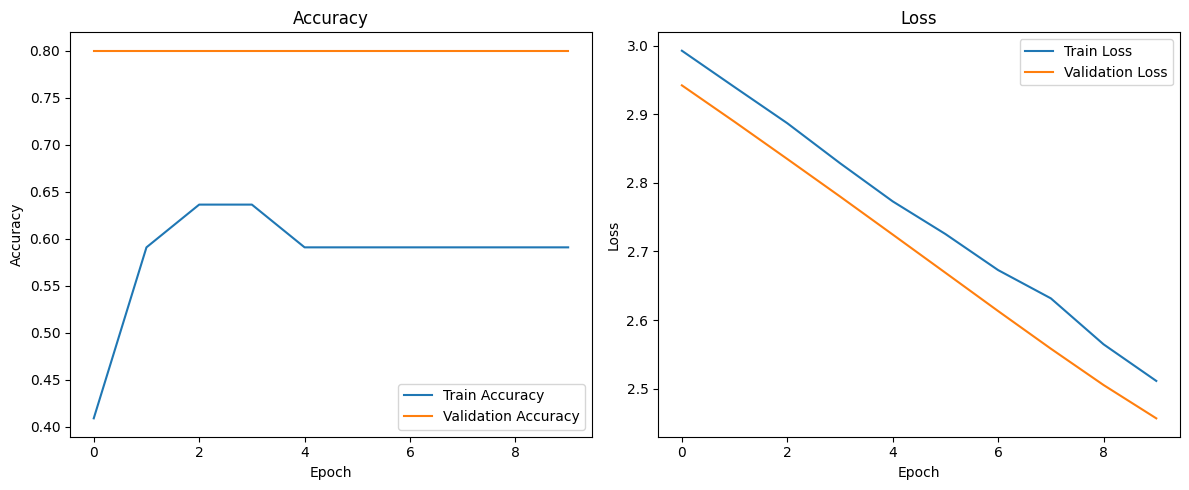

In [5]:
def plot_training_history(history):
    # Tracer l'accuracy
    plt.figure(figsize=(12, 5))
    
    # Plot de l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot de la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction avec l'historique de l'entraînement
plot_training_history(history)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import json

# Sauvegarde du tokenizer en JSON
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


In [7]:
# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('sentiment_lstm_model.keras')

# Fonction pour prédire le sentiment d'un tweet
def predict_sentiment(tweet):
    sequence = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(sequence, maxlen=128, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    positive_proba = prediction[0][0]
    return positive_proba

# Exemples de tweets pour les tests
test_tweets = [
    "I can't believe how terrible this service is. Absolutely awful!",
    "Worst experience ever. Totally disappointing and frustrating.",
    "Everything about this product is just so bad. Waste of money.",
    "I'm really not happy with how things turned out. Expected better.",
    "Not impressed with the quality at all. Quite disappointing.",
    "This is not what I ordered. Very misleading.",
    "I was hoping for more, but it's just okay. Not quite what I wanted.",
    "It's alright, but it could be a lot better. Needs improvement.",
    "Service was slow and unresponsive, but the product was decent.",
    "It’s fine, nothing too special but not too bad either.",
    "I had an average experience, nothing to write home about.",
    "It’s okay, does the job but doesn’t exceed expectations.",
    "Pretty good overall, just a few minor issues here and there.",
    "Decent product for the price, happy with the purchase.",
    "Met most of my expectations, would recommend with some reservations.",
    "Really satisfied with this. It’s just what I needed.",
    "Great product, would definitely buy again. Very happy.",
    "Good service and quality, met my expectations well.",
    "Absolutely love this! Exceeded all my expectations.",
    "Best purchase I've made in a while. Highly recommend!",
    "Fantastic experience from start to finish. Couldn't be happier!"
]

for tweet in test_tweets:
    prediction = predict_sentiment(tweet)
    sentiment = "Positif" if prediction > 0.5 else "Négatif"
    print(f"Tweet: {tweet}")
    print(f"Score: {prediction:.4f}, Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Tweet: I can't believe how terrible this service is. Absolutely awful!
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tweet: Worst experience ever. Totally disappointing and frustrating.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tweet: Everything about this product is just so bad. Waste of money.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tweet: I'm really not happy with how things turned out. Expected better.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tweet: Not impressed with the quality at all. Quite disappointing.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tweet: This is not what I ordered. Very misleading.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tweet: I was hoping for more, but it's just okay. Not quite what I wanted.
Score: 0.2566, Sentiment: Négatif
1/1 ━━━━━━━━━━━━━━━━━━